<h2 align='center'> Classification Using Ensemble Methods </h2>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [24]:
data = pd.read_csv('Human_Activity_Recognition_Using_Smartphones_Data.csv')

In [25]:
data.shape

(10299, 562)

In [26]:
print(data.max().any() > 1.0)
print(data.min().any() < -1.0)
# No scaling required for trees usually

False
False


In [27]:
float_columns = data.columns[data.dtypes == np.float]

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
le = LabelEncoder()
data['Activity'] = le.fit_transform(data['Activity'])

In [30]:
data.Activity.value_counts(normalize=True)

0    0.188756
2    0.185067
1    0.172541
3    0.167201
5    0.149917
4    0.136518
Name: Activity, dtype: float64

* Classes are balanced

#### The data is clean and doesnot require much preprocessing

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X = data.drop('Activity', axis=1)
y = data.Activity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

* `max_features` argument in `GradientBoostingClassifier` is used to limit the no.of features to build a tree.
* Boosting techniques often take really long time to execute.
* `max_leaf_nodes` is used to limit the leaf nodes of a tree.In general a value between 8 and 32 is used.
* Limiting features  wouldn't hurt the performance. You can use Cross validation to find which no.of features help find the best model.


In [34]:
GBC = GradientBoostingClassifier(random_state=42)

In [43]:
n_estimators = [15, 25, 50, 100, 200, 400]
errors_list = list()
for n in n_estimators:
    GBC.set_params(n_estimators=n)
    GBC.fit(X_train, y_train)
    preds = GBC.predict(X_test)
    error = 1 - accuracy_score(y_test, preds)
    print('ending run on estimators = {}'.format(n))
    errors_list.append(pd.Series({'n_trees':n, 'error':error}))
    pickle.dump(GBC, open('GBC' + str(n)+'.p', 'wb'))

# This bit of code took almost 3 hrs to execute as i've left everything in default.

ending run on estimators = 15
ending run on estimators = 25
ending run on estimators = 50
ending run on estimators = 100
ending run on estimators = 200
ending run on estimators = 400


In [44]:
errors_frame = pd.concat(errors_list, axis=1).T.set_index('n_trees')
errors_frame

,error
n_trees,
15.0,0.052427
25.0,0.035437
50.0,0.019903
100.0,0.014078
200.0,0.012621
400.0,0.010680


<AxesSubplot:xlabel='n_trees'>

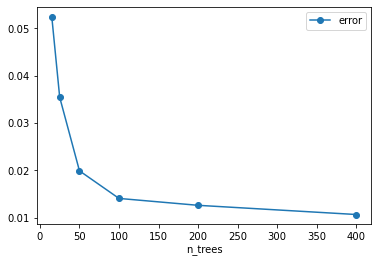

In [45]:
errors_frame.plot(marker='o')

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
model = GBC.set_params(n_estimators=200)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       0.99      0.97      0.98       377
           2       0.97      0.99      0.98       354
           3       1.00      1.00      1.00       369
           4       1.00      0.99      0.99       284
           5       0.99      1.00      0.99       270

    accuracy                           0.99      2060
   macro avg       0.99      0.99      0.99      2060
weighted avg       0.99      0.99      0.99      2060



<AxesSubplot:>

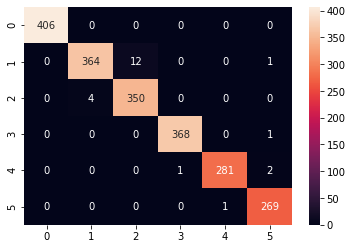

In [49]:
preds = model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')

* Model did a pretty good job in classifying the train data and generalize to test data
* Model confuses in classifying class 1 and class 2 

### GradientBoost classifier with GridSearchCV

In [50]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [51]:
params_grid = {'n_estimators':[300],
               'learning_rate':[0.1, 0.001, 0.0001, 0.01],
               'max_leaf_nodes':[24, 21, 30],
               'subsample': [1.0, 0.5], 
               'max_features':[1, 2, 3, 4, 5, 6]}
GDC = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=params_grid, n_jobs=-1)
GDC = GDC.fit(X_train, y_train)

* learning rate here is similar to penalizing the cost function.
* sub_sample is to fit only on a portion of data.


In [52]:
GDC.best_estimator_

GradientBoostingClassifier(max_features=6, max_leaf_nodes=24, n_estimators=300,
                           random_state=42)

In [53]:
y_pred = GDC.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       0.99      0.97      0.98       377
           2       0.97      0.99      0.98       354
           3       0.99      1.00      1.00       369
           4       1.00      0.99      1.00       284
           5       0.99      1.00      0.99       270

    accuracy                           0.99      2060
   macro avg       0.99      0.99      0.99      2060
weighted avg       0.99      0.99      0.99      2060



* Gradient boost did good with 200 trees. Here with 400 trees we limited the max_features but still it achieved almost similar peformance as compared to using all the features.

<AxesSubplot:>

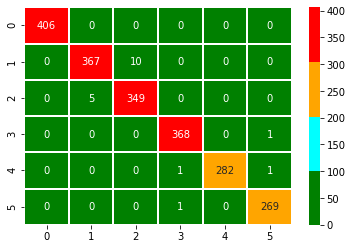

In [55]:
sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=1, cmap=['green', 'cyan', 'orange', 'red'], fmt='d', annot=True)

In [56]:
ADC = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))
params_grid = {'n_estimators':[100, 150, 400], 'learning_rate':[0.001, 0.01]}
GADC = GridSearchCV(estimator=ADC, param_grid=params_grid, n_jobs=-1, scoring='accuracy')
GADC = GADC.fit(X_train, y_train)

In [57]:
pred = GADC.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      0.01      0.02       377
           2       0.49      1.00      0.65       354
           3       0.84      0.92      0.88       369
           4       0.96      0.70      0.81       284
           5       0.78      0.89      0.83       270

    accuracy                           0.75      2060
   macro avg       0.84      0.75      0.70      2060
weighted avg       0.85      0.75      0.69      2060



<AxesSubplot:>

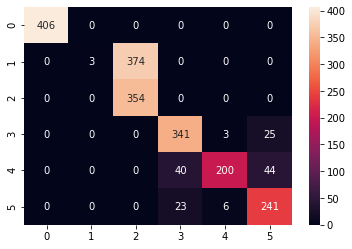

In [58]:
sns.heatmap(confusion_matrix(y_test, pred), fmt='d', annot=True)

* AdaBoost did a really bad job at classifying this data

### VotingClassifer

   * A voting classifier takes in a list of classifiers and takes a vote to return the best estimate for that example. 

In [59]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore') # convergence warnings

In [60]:
Logreg_L2= LogisticRegression(penalty='l2', solver='saga')
Logreg_L2 = Logreg_L2.fit(X_train, y_train)

In [61]:
logistic_preds = Logreg_L2.predict(X_test)
print(classification_report(y_test, logistic_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       0.96      0.96      0.96       377
           2       0.96      0.96      0.96       354
           3       0.99      0.99      0.99       369
           4       1.00      0.99      0.99       284
           5       0.99      0.99      0.99       270

    accuracy                           0.98      2060
   macro avg       0.98      0.98      0.98      2060
weighted avg       0.98      0.98      0.98      2060



Text(22.5, 0.5, 'true')

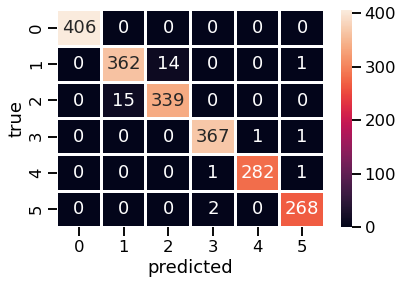

In [62]:
sns.set_context('talk')
sns.heatmap(confusion_matrix(y_test, logistic_preds), fmt='d', annot=True, linewidths=2)
plt.xlabel('predicted')
plt.ylabel('true')

In [63]:
from sklearn.ensemble import VotingClassifier

In [64]:
estimators = [('LR_L2', Logreg_L2), ('GB', model)]

In [65]:
Vc = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
Vc = Vc.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       0.98      0.97      0.97       377
           2       0.97      0.97      0.97       354
           3       1.00      1.00      1.00       369
           4       1.00      1.00      1.00       284
           5       0.99      1.00      1.00       270

    accuracy                           0.99      2060
   macro avg       0.99      0.99      0.99      2060
weighted avg       0.99      0.99      0.99      2060



<AxesSubplot:>

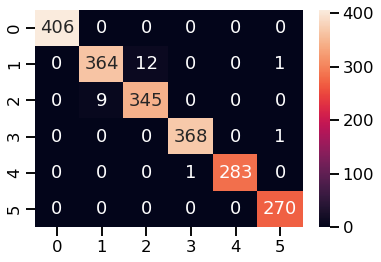

In [66]:
print(classification_report(y_test, Vc.predict(X_test)))
sns.heatmap(confusion_matrix(y_test, Vc.predict(X_test)), fmt='d', annot=True)